In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import os
import seaborn as sns

%matplotlib inline

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
train = pd.read_csv('data/train_balanced_5k.csv')

train.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=1)

part_codes = {'Ghost':0, 'Electron':11, 'Muon':13, 'Pion':211, 'Kaon':321, 'Proton':2212}
particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]

train_types = np.abs(train['MCParticleType'])
train_types_encoding = {part_codes[code]:index for index, code in enumerate(particles)}
labels = train_types.apply(lambda x: train_types_encoding[x])

mc_features = ['HasMC', 'MCParticleType', 'MCParticleP', 'MCParticlePt', 'MCVirtualMass', 
               'MCFromB', 'MCFromD', 'MCVertexType', 'MCVertexX', 'MCVertexY', 'MCVertexZ', 
               'piplus_OWNPV_X', 'piplus_OWNPV_Y', 'piplus_OWNPV_Z', 'piplus_OWNPV_XERR', 
               'piplus_OWNPV_YERR', 'piplus_OWNPV_ZERR', 'piplus_OWNPV_CHI2', 'piplus_OWNPV_NDOF', 
               'piplus_IP_OWNPV', 'piplus_IPCHI2_OWNPV', 'nCandidate', 'totCandidates', 'EventInSequence', 
               'TrackHistory', 'TrackType', 'RecoPIDcode']

constant_features = ['TrackMatchChi2', 'TrackCloneDist', 'RichUsedAero']

features = list(set(train.columns) - set(mc_features + constant_features))

train = train.loc[:, features]

print train.shape
print features

(33660, 77)
['RichDLLpi', 'RichDLLe', 'CaloBremChi2', 'RichDLLp', 'HcalPIDe', 'RichAbovePiThres', 'InAccHcal', 'CaloElectronMatch', 'InAccEcal', 'TrackFitTChi2', 'NumUpstreamTracks', 'CaloBremMatch', 'NumProtoParticles', 'MuonIsLooseMuon', 'InAccSpd', 'CaloEcalChi2', 'MuonMuLL', 'TrackFitVeloNDoF', 'TrackLikelihood', 'CaloSpdE', 'RichAboveKaThres', 'EcalPIDe', 'CaloNeutralSpd', 'CombDLLmu', 'CombDLLpi', 'TrackGhostProbability', 'CaloTrMatch', 'MuonNShared', 'RichAboveMuThres', 'CaloNeutralEcal', 'RichAboveElThres', 'EcalPIDmu', 'NumMuonTracks', 'TrackFitVeloChi2', 'NumSPDHits', 'InAccPrs', 'CombDLLe', 'CombDLLk', 'CaloChargedSpd', 'NumDownstreamTracks', 'CaloEcalE', 'CaloClusChi2', 'CaloNeutralPrs', 'RichDLLbt', 'BremPIDe', 'CombDLLp', 'RichUsedR2Gas', 'InAccBrem', 'HcalPIDmu', 'TrackNumDof', 'PrsPIDe', 'RichDLLk', 'NumCaloHypos', 'VeloCharge', 'NumLongTracks', 'RichUsedR1Gas', 'NumRich1Hits', 'TrackP', 'CaloChargedPrs', 'MuonBkgLL', 'RichAbovePrThres', 'TrackFitMatchChi2', 'TrackFitTN

In [3]:
test = pd.read_csv('/notebooks/data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long/data_eval.csv')
test.drop('Unnamed: 0', axis=1, inplace=1)

part_codes = {'Ghost':0, 'Electron':11, 'Muon':13, 'Pion':211, 'Kaon':321, 'Proton':2212}

test_types = np.abs(test['MCParticleType'])
mask = test_types.isin(part_codes.values())
test = test.loc[mask]
test_types = test_types[mask]
test_labels = test_types.apply(lambda x: train_types_encoding[x])

test = test.loc[:, features]

print test.shape

(999566, 77)


In [4]:
from sklearn.preprocessing import Imputer

to_log = ['CaloNeutralPrs', 'CaloPrsE', 'CaloHcalE', 'CaloNeutralEcal', 'CaloTrMatch', 'CaloElectronMatch', 'CaloChargedPrs',
          'MuonNShared', 'CaloBremMatch', 'TrackPt', 'TrackP', 'NumDownstreamTracks', 'CaloEcalChi2', 'NumRich1Hits',
          'NumMuonTracks', 'NumTTracks', 'TrackFitMatchChi2', 'TrackDOCA', 'CaloClusChi2', 'TrackFitVeloChi2',
          'CaloBremChi2', 'CaloChargedEcal', 'NumSPDHits', 'NumVeloTracks', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'NumRich2Hits', ]

to_log_negative = ['CaloTrajectoryL', 'MuonMuLL', 'RichDLLbt', 'CombDLLp', 'RichDLLe', 'TrackLikelihood', 'CombDLLk', 
                   'RichDLLp', 'CaloEcalE', 'RichDLLmu', 'RichDLLk']

# CaloChargedSpd - 1 or -999
# CombDLLpi, RichDLLpi  0 or -999

def log1p_negative(array):
    negative = array < 0
    array = np.log1p(np.abs(array))
    array[negative] *= -1
    return array

def preprocess_data(X):
    X.loc[:, 'CaloChargedSpd'].replace(-999, 0, inplace=1)
    X.loc[:, ['CombDLLpi', 'RichDLLpi']].replace(-999, 1, inplace=1)
    
    X[X == -999] = np.nan
    X_columns = X.columns

    imp = Imputer()
    X = imp.fit_transform(X)
    X = pd.DataFrame(data=X, columns=X_columns)

    for col in to_log:
        X[col] = np.log1p(X[col])
    for col in to_log_negative:
        X[col] = log1p_negative(X[col])
    return X
train = preprocess_data(train)
test = preprocess_data(test)

In [5]:
%%time

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=2.5, penalty='l1')
lr.fit(train[features], labels)

CPU times: user 3min 32s, sys: 14 ms, total: 3min 32s
Wall time: 3min 32s


In [6]:
%%time
preds = lr.predict_proba(test[features])

CPU times: user 1.53 s, sys: 544 ms, total: 2.07 s
Wall time: 2.07 s


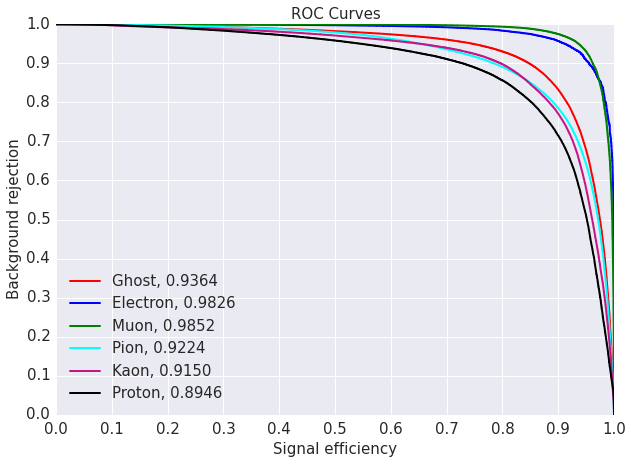

In [7]:
from utils import get_roc_curves, get_roc_auc_matrix

_ = get_roc_curves(test_labels, preds, particles)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


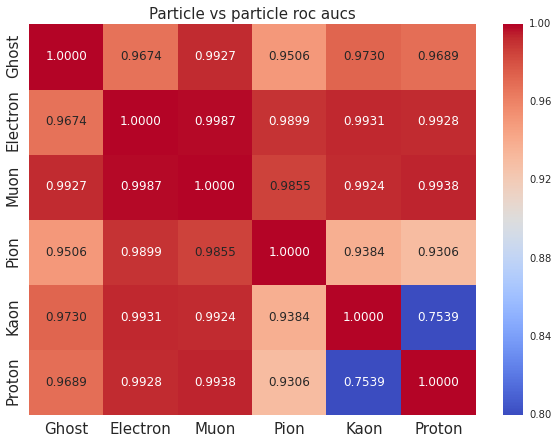

In [8]:
roc_matrix = get_roc_auc_matrix(test_labels, preds, particles)

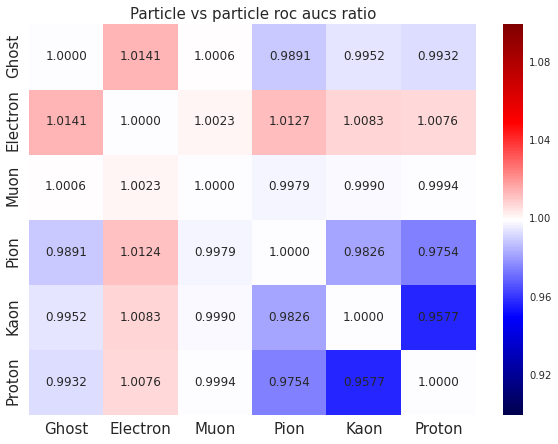

In [9]:
from utils import get_roc_auc_ratio_matrix

roc_matrix_baseline = pd.read_csv('/notebooks/eltyshev/PID/python/class_vs_class_roc_auc_matrix_baseline.csv', index_col='Unnamed: 0')

ratio = get_roc_auc_ratio_matrix(roc_matrix, roc_matrix_baseline)

In [10]:
from itertools import combinations

sum = 0.0

for ind1, ind2 in combinations(range(6), 2):
    sum += roc_matrix.iloc[ind1, ind2]
print 'Avg. pairwise ROC AUC: {0:0.4f}'.format(sum / 15)

Avg. pairwise ROC AUC: 0.9615


In [11]:
from sklearn.metrics import log_loss

print log_loss(test_labels, preds)

0.739172786207


In [12]:
%%time
import utils

flatness = utils.get_flatness_table(test, test_labels, preds, particles)

CPU times: user 17min 59s, sys: 1.46 s, total: 18min
Wall time: 18min 2s


In [13]:
flatness[['TrackP', 'TrackPt']].values.mean()

0.028048965314050087